In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from datetime import date, datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn import metrics   
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import scipy.stats as stats
import os
import pickle

%matplotlib widget

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2

load_data = 0
rextract = 0
retrain = 1
# Load data
# fig,ax = plt.subplots(2,5)
segs = []
qsms = []
voxel_sizes = []
trackers = []
directory = 'F:\dbs\stn-dbs\Cornell_anonymized'
case_list = []
if load_data == 1:
    for filename in os.listdir(directory):
        f = os.path.join(directory,filename)
        print(f)
    
        seg = nib.load(f+'/Rh Mri Brain With Without Contrast/seg.nii.gz')
                    
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata())

        qsm = nib.load(f+'/Rh Mri Brain With Without Contrast/qsm.nii.gz')
        qsms.append(qsm.get_fdata())
            
        case_list.append(filename)
        n_cases = len(segs)

        label_min = np.partition(np.unique(seg.get_fdata().ravel()),1)[1]
        label_max = np.amax(seg.get_fdata())

In [4]:
# Define feature extraction
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()

# Generate feature structure Phi from all ROIs and all cases
if rextract == 1:
    Phi = []

    # Training cases
    for i in range(n_cases):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_sizes[i].tolist())
        qsm_sitk = sitk.GetImageFromArray(qsms[i])
        qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
        for j in range(int(label_min),int(label_max+1)):
            featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
            Phi.append(featureVector)
    # Save feature vector
    with open('../features/Phi_57','wb') as fp:  
        pickle.dump(Phi,fp)


In [5]:
with open('../features/Phi_57','rb') as fp:  
    Phi = pickle.load(fp)

In [6]:
%%html
   <style>
   .cell-output-ipywidget-background {
      background-color: transparent !important;
   }
   .jp-OutputArea-output {
      background-color: transparent;
   }  
   </style>
   

In [7]:
 # SAS features 
subject_id = np.linspace(1,27,27).astype(int)
pre_sas_on = np.array((8,2,12,17,11,22,2,5,13,4,11,7,7,16,9,8,9,13,10,11,6,5,17,12,11,21,9)).T
post_sas_on = np.array((21,3,19,13,13,14,11,12,23,12,4,6,11,28,17,8,21,8,17,11,9,20,17,19,15,19,11)).T
per_change = (post_sas_on-pre_sas_on)/pre_sas_on
pre_sas_off = np.array((13,2,9,20,21,12,3,27,22,29,30,17,13,27,9,8,16,31,10,2,8,5,17,14,8,12,8))
lct_change = (pre_sas_off-pre_sas_on)/pre_sas_off
dbs_change = (post_sas_on-pre_sas_off)/pre_sas_off
ap = np.array(('Y','N','Y','Y','Y','Y','N','Y','Y','Y','Y','Y','N','Y','Y','N','Y','Y','Y','Y','N','N','Y','N','Y','N','N')).T
ap[ap=='Y'] = 1 
ap[ap=='N'] = 0
bi_sas = ((ap)).astype('float')
n_cases = pre_sas_on.__len__()

In [11]:
j

27

In [45]:
n_cases = subject_id.__len__()
x_row = []
per_change_train = []
ut = np.zeros((subject_id.__len__()))
ut_clf = np.zeros((subject_id.__len__()))
clf_alphas = np.zeros((subject_id.__len__()))
sfm_alphas = np.zeros((subject_id.__len__()))
svr_cs = np.zeros((subject_id.__len__()))
svr_epsilons = np.zeros((subject_id.__len__()))
for j in np.arange(1,np.max(subject_id)+1):
    feat_counts = 0
    if j in subject_id:
        # Extract numeric feature values
        n_ROIs = 2
        keys = []
        if [subject_id == j].__len__()>0:
                for iii in np.arange(0,n_ROIs):
                    featureVector = Phi[2*(j-1)+iii]
                    print('Appending feature vectors at index ',2*j+iii,' for case ',j,' ROI number ',iii)
                    for key,value in six.iteritems(featureVector):
                        if 'diagnostic' in key:
                            next
                        else:
                            try:
                                x_row.append(value.ravel())
                                feat_counts = feat_counts+1  
                            except:
                                x_row.append(value)
                                keys.append(key)
                                feat_counts = feat_counts+1

        if iii == 1 and pre_sas_off[subject_id == j].__len__()>0:
            x_row.append(pre_sas_off[subject_id == j])
            x_row.append(pre_sas_on[subject_id == j])
            x_row.append(bi_sas[subject_id == j].astype('float'))
            keys.append('pre_sas_off')
            keys.append('pre_sas_on')
            keys.append('bi_sas')
            per_change_train.append(per_change[subject_id == j])
            print('Appending pre-SAS off score for case ',j)
            print('Appending pre-SAS on score for case ',j)
            print('Appending target for case ',j)
        jj = int(np.where(subject_id==j)[0])
    print('Appended ',feat_counts,' features to case ',j)            

X0 = np.array(x_row)
X = X0.reshape((n_cases,int(len(X0)/(n_cases))))
# Normalize testing and training cases together
#   Set with_mean=False to preserve data sparsity
#   And with_std=False 
#   However,need a significant number of samples to do this
scaler = MinMaxScaler()
X_t = scaler.fit_transform(X)




Appending feature vectors at index  2  for case  1  ROI number  0
Appending feature vectors at index  3  for case  1  ROI number  1
Appending pre-SAS off score for case  1
Appending pre-SAS on score for case  1
Appending target for case  1
Appended  3376  features to case  1
Appending feature vectors at index  4  for case  2  ROI number  0
Appending feature vectors at index  5  for case  2  ROI number  1
Appending pre-SAS off score for case  2
Appending pre-SAS on score for case  2
Appending target for case  2
Appended  3376  features to case  2
Appending feature vectors at index  6  for case  3  ROI number  0
Appending feature vectors at index  7  for case  3  ROI number  1
Appending pre-SAS off score for case  3
Appending pre-SAS on score for case  3
Appending target for case  3
Appended  3376  features to case  3
Appending feature vectors at index  8  for case  4  ROI number  0
Appending feature vectors at index  9  for case  4  ROI number  1
Appending pre-SAS off score for case  4


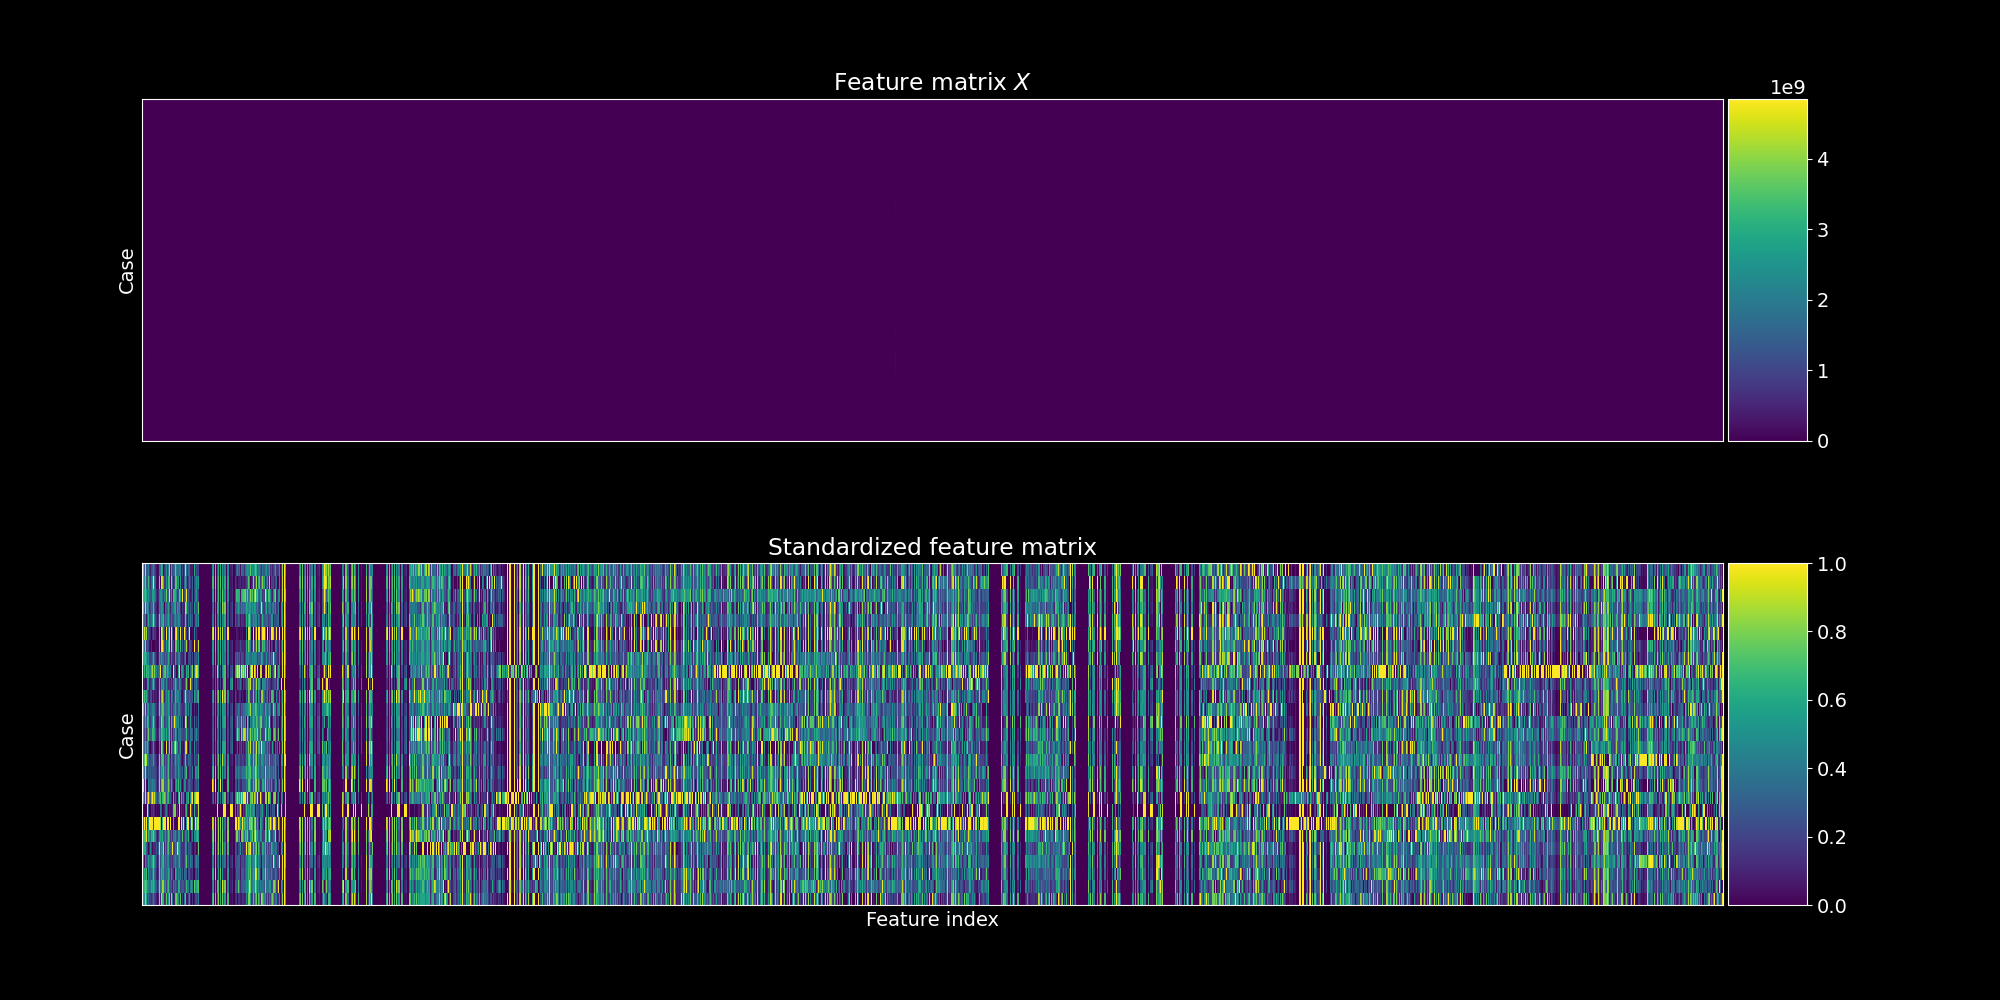

In [46]:
fig,ax = plt.subplots(2,1)
plt.style.use('dark_background')
im0 = ax[0].pcolor(X)
im1 = ax[1].pcolor(X_t)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('Feature index')
ax[0].set_ylabel('Case')
ax[1].set_ylabel('Case')
divider0 = make_axes_locatable(ax[0])
divider1 = make_axes_locatable(ax[1])
cax0 = divider0.append_axes('right',size='5%',pad=0.05)
fig.colorbar(im0,cax=cax0,orientation='vertical')
cax1 = divider1.append_axes('right',size='5%',pad=0.05)
fig.colorbar(im1,cax=cax1,orientation='vertical')
ax[1].set_title('Standardized feature matrix')
ax[0].set_title('Feature matrix $X$');

plt.tight_layout()
fig.set_size_inches(20,10)



In [47]:
per_change_train.__len__()
per_change_train = np.flipud(per_change_train)

In [48]:
if retrain == 1:
    #fig,ax = plt.subplots(1,1)
    for j in np.arange(1,np.max(subject_id)):
        if j in subject_id:
            # Remove the test case
            jj = int(np.where(subject_id==j)[0])
            X_j = np.delete(X_t,jj,0)
            per_change_train_j = np.delete(per_change_train,jj,0)
            # Debug
            print('Excluding subject',str(subject_id[jj]),'at index',jj,'in target vector','from training feature vector of shape',str(X_t.shape),'by deleting row',str(jj),'to create new training feature vector of shape',str(X_j.shape))
            if (sum(sum(np.isnan(X))))>0:
                print('NaN detected in feature vector')

            # Cross-validation for model selection
            cv = KFold((X_j.shape[0]-2))
            # Identify most important features
            # Do not assume data is centered,fit_intercept=True
            clf_in = LassoCV(fit_intercept=True,max_iter=100000).fit(X_j,np.ravel(per_change_train_j))

            clf_alphas[jj] = clf_in.alpha_
            ut[jj] = clf_in.predict(X_t[jj,:].reshape(1,-1))
            print('Predicted percentage change of',ut[jj],'for case',subject_id[jj],'with alpha',clf_in.alpha_)
            print('True percentage change',per_change_train[jj])


Excluding subject 1 at index 0 in target vector from training feature vector of shape (27, 3379) by deleting row 0 to create new training feature vector of shape (26, 3379)
Predicted percentage change of 0.9993917210906303 for case 1 with alpha 0.11015460000364702
True percentage change [0.22222222]
Excluding subject 2 at index 1 in target vector from training feature vector of shape (27, 3379) by deleting row 1 to create new training feature vector of shape (26, 3379)
Predicted percentage change of 0.7462539094845423 for case 2 with alpha 0.11720217983825476
True percentage change [-0.0952381]
Excluding subject 3 at index 2 in target vector from training feature vector of shape (27, 3379) by deleting row 2 to create new training feature vector of shape (26, 3379)
Predicted percentage change of 0.7824099669170463 for case 3 with alpha 0.1430740934691083
True percentage change [0.36363636]
Excluding subject 4 at index 3 in target vector from training feature vector of shape (27, 3379) b

In [49]:
if retrain == 1:
    #fig,ax = plt.subplots(1,1)
    for j in np.arange(1,np.max(subject_id)):
        if j in subject_id:
            # Remove the test case
            jj = int(np.where(subject_id==j)[0])
            X_j = np.delete(X_t,jj,0)
            per_change_train_j = np.delete(per_change_train,jj,0)
            # Debug
            print('Excluding subject',str(subject_id[jj]),'at index',jj,'in target vector','from training feature vector of shape',str(X_t.shape),'by deleting row',str(jj),'to create new training feature vector of shape',str(X_j.shape))

            clf = Lasso(alpha=np.median(clf_alphas),fit_intercept=True,max_iter=10000).fit(X_j,np.ravel(per_change_train_j))
            ut_clf[jj] = clf.predict(X_t[jj,:].reshape(1,-1))

Excluding subject 1 at index 0 in target vector from training feature vector of shape (27, 3379) by deleting row 0 to create new training feature vector of shape (26, 3379)
Excluding subject 2 at index 1 in target vector from training feature vector of shape (27, 3379) by deleting row 1 to create new training feature vector of shape (26, 3379)
Excluding subject 3 at index 2 in target vector from training feature vector of shape (27, 3379) by deleting row 2 to create new training feature vector of shape (26, 3379)
Excluding subject 4 at index 3 in target vector from training feature vector of shape (27, 3379) by deleting row 3 to create new training feature vector of shape (26, 3379)
Excluding subject 5 at index 4 in target vector from training feature vector of shape (27, 3379) by deleting row 4 to create new training feature vector of shape (26, 3379)
Excluding subject 6 at index 5 in target vector from training feature vector of shape (27, 3379) by deleting row 5 to create new traini

In [50]:
if retrain == 1:
    with open('lasso_pred.npy','wb') as f:
        np.save(f,ut)
else:
    with open('lasso_pred.npy','rb') as f:
        ut = np.load(f)

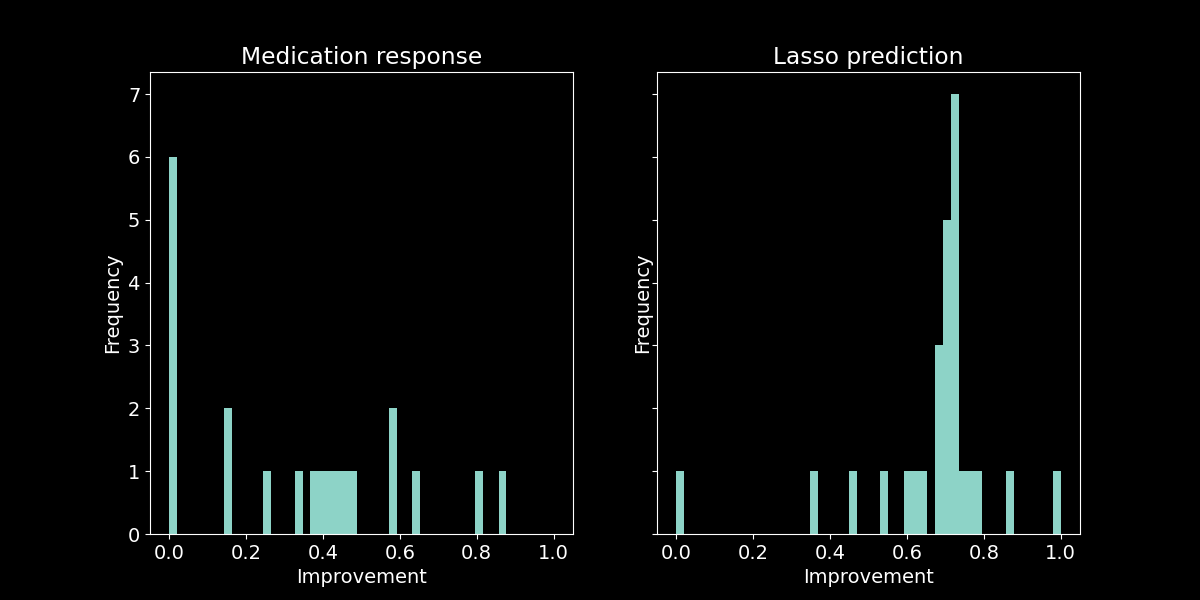

In [51]:
[fig,ax] = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].hist([lct_change],bins=np.linspace(0,1))
ax[0].set_title('Medication response')
ax[0].set_xlabel('Improvement')
ax[0].set_ylabel('Frequency')
ax[1].hist([ut],bins=np.linspace(0,1))
ax[1].set_title('Lasso prediction')
ax[1].set_xlabel('Improvement')
ax[1].set_ylabel('Frequency')
fig.set_size_inches(12,6)

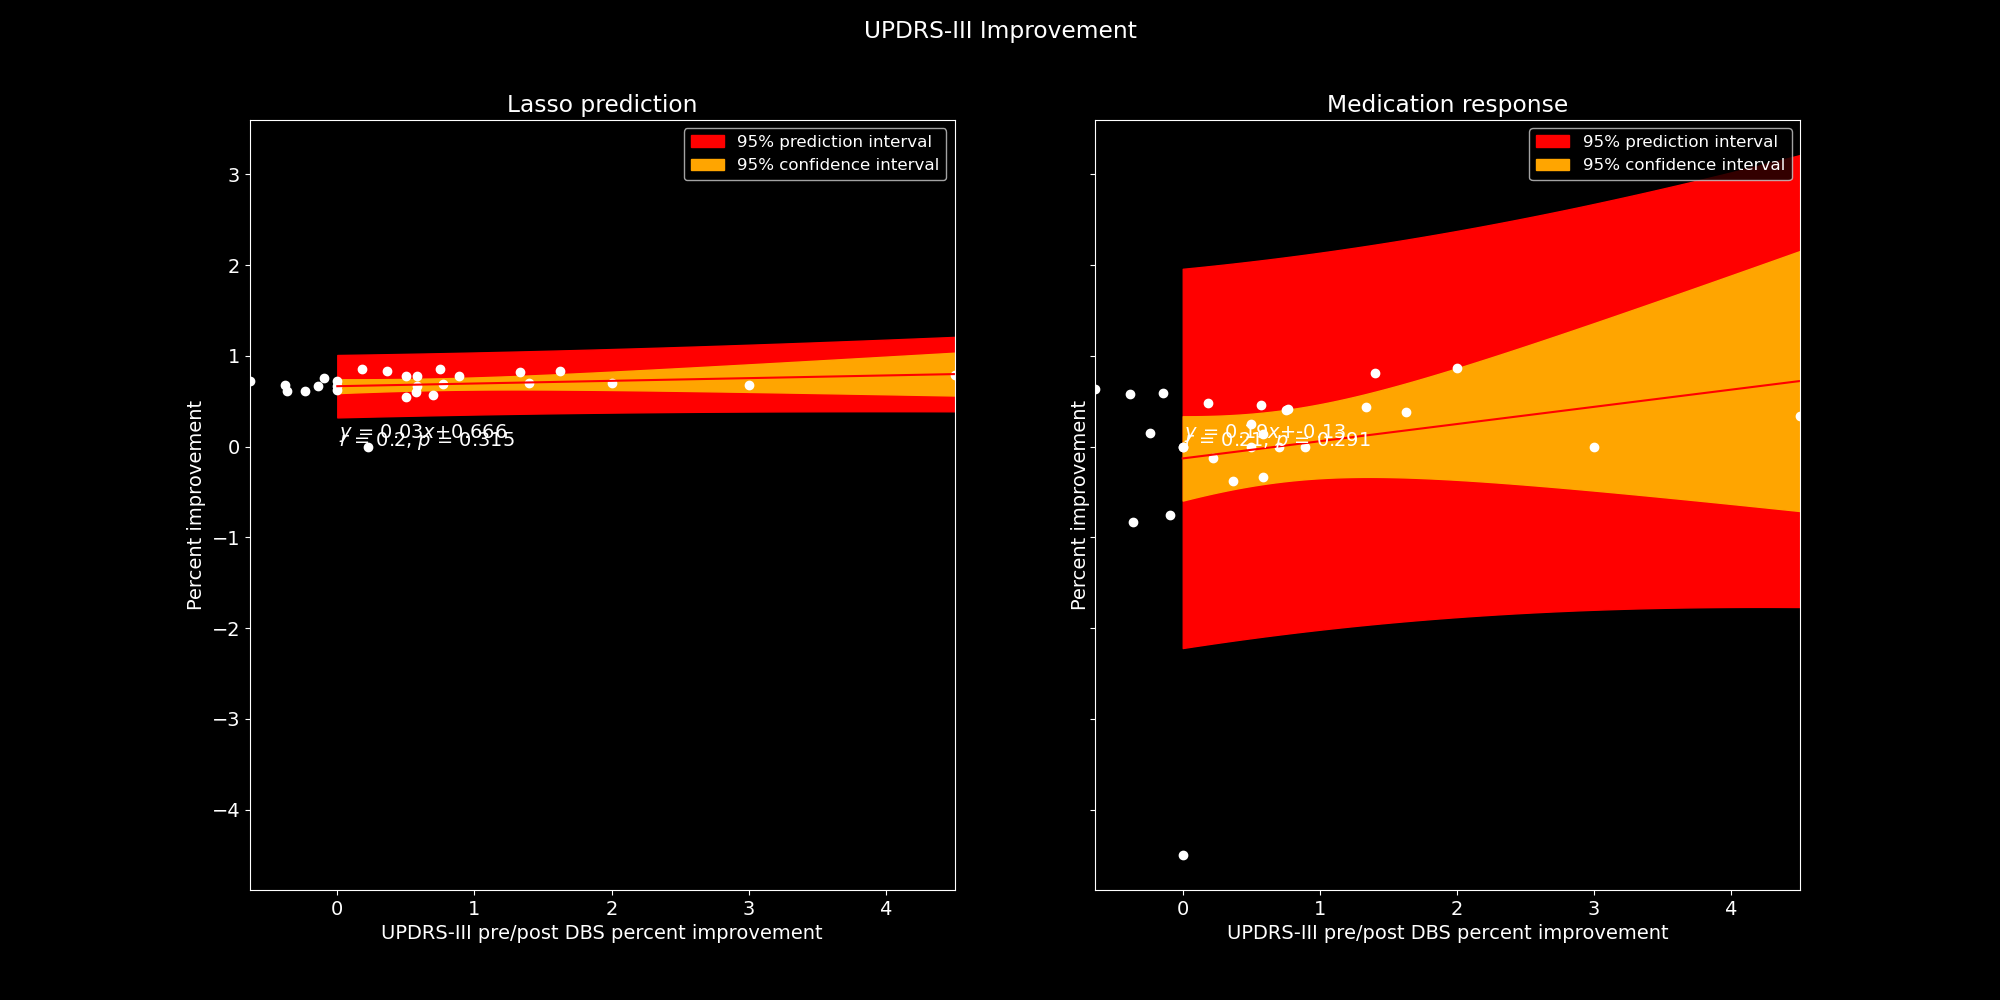

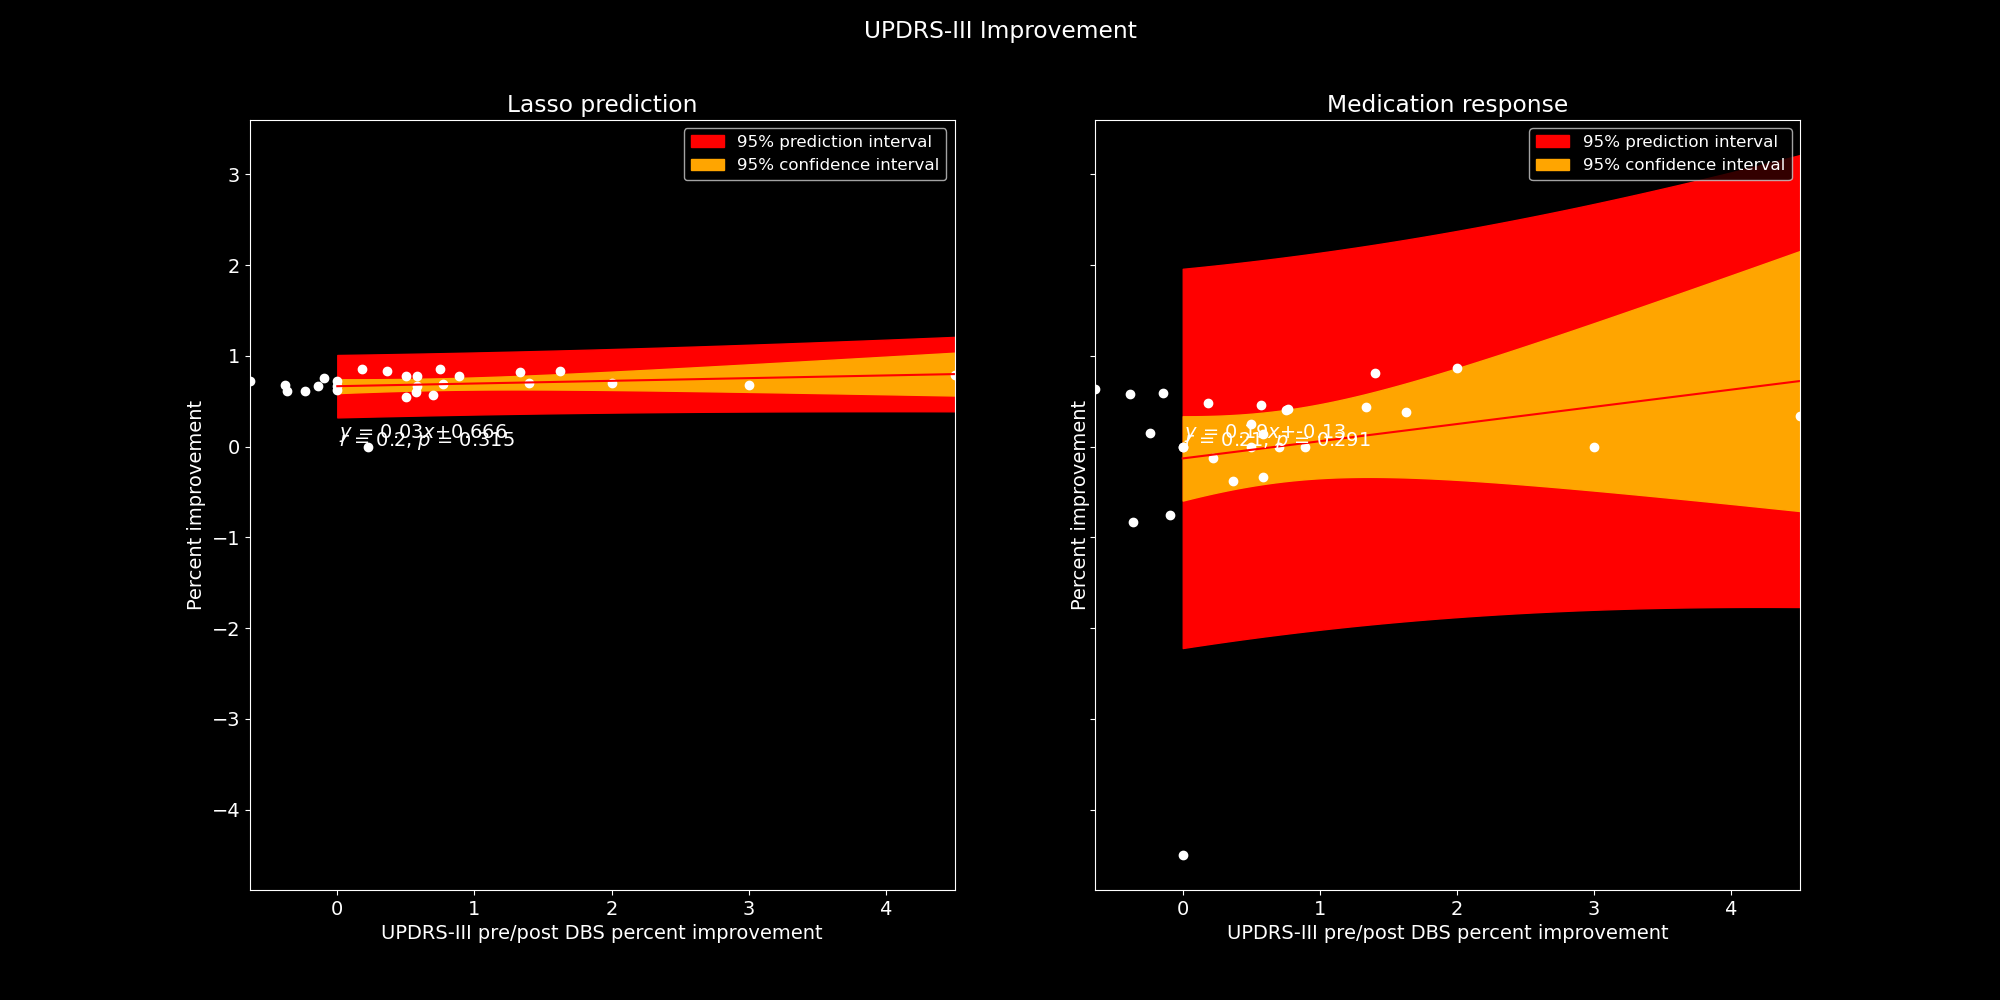

In [52]:
x = per_change
y = ut_clf

slope,intercept = np.polyfit(x,y,1)  # linear model adjustment
y_model = np.polyval([slope,intercept],x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 2                             # number of parameters
dof = n-m                       # degrees of freedom
t = stats.t.ppf(0.975,dof)       # Students statistic of interval confidence
residual_ut = y-y_model
std_error = (np.sum(residual_ut**2)/dof)**(1/2)   # Standard deviation of the error

# Pearson's correlation coefficient
numerator = np.sum((x-x_mean)*(y-y_mean))
denominator = (np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))**.5
correlation_coef = numerator/denominator
r = correlation_coef
tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
# p-value for 2-sided test
pv = 2*(1-stats.t.cdf(abs(tr), dof))
# # mean squared error
MSE = 1/n*np.sum((y-y_model)**2)

# to plot the adjusted model
x_line = np.linspace(0,np.max(x),100)
y_line = np.polyval([slope,intercept],x_line)

# confidence interval
ci = t*std_error*(1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5
# predicting interval
pi = t*std_error*(1+1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5  


plt.rcParams.update({'font.size': 14})
[fig,ax] = plt.subplots(1,2,sharex=True,sharey=True)

ax[0].plot(x,y,'o',color = 'white')
ax[0].plot(x_line,y_line,color = 'red')
ax[0].fill_between(x_line,y_line+pi,y_line-pi,color = 'red',label = '95% prediction interval')
ax[0].fill_between(x_line,y_line+ci,y_line-ci,color = 'orange',label = '95% confidence interval')

ax[0].set_xlabel('UPDRS-III pre/post DBS percent improvement')
ax[0].set_ylabel('Percent improvement')
ax[0].set_title('Lasso prediction')

ax[0].text(0.01,0.1,'$y$ = '+ str(np.round(slope,2))+'$x$'+'+'+str(np.round(intercept,3)),color='w')
ax[0].text(0.01,0.005,'$r$ = '+str(np.round(r,2))+', $p$ = '+str(round(pv,3)),color='w')

ax[0].margins(x=0)
fig.set_size_inches(20,10)
ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)


## Medication response
x = per_change
y = lct_change

# Fit and evaluate linear model
slope,intercept = np.polyfit(x,y,1)
y_model = np.polyval([slope,intercept],x)   

# Prepare correlation stats
x_mean = np.mean(x)
y_mean = np.mean(y)
# Sample size
n = x.size         
# Parameters assuming a normal distribution              
m = 2
# Degrees of freedom                            
dof = n-m
# Students statistic of interval confidence                      
t = stats.t.ppf(0.975,dof)      
# Standard deviation of the error
residual_lct = y-y_model
std_error = (np.sum(residual_lct**2)/dof)**(1/2)   

# Pearson's correlation coefficient
numerator = np.sum((x-x_mean)*(y-y_mean))
denominator = (np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))**.5
correlation_coef = numerator/denominator
r = correlation_coef
tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
# p-value for 2-sided test
pv = 2*(1-stats.t.cdf(abs(tr), dof))
# # mean squared error
MSE = 1/n*np.sum((y-y_model)**2)

# to plot the adjusted model
x_line = np.linspace(0,np.max(x),100)
y_line = np.polyval([slope,intercept],x_line)

# confidence interval
ci = t*std_error*(1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5
# predicting interval
pi = t*std_error*(1+1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**.5  



ax[1].plot(x,y,'o',color = 'white')
ax[1].plot(x_line,y_line,color = 'red')
ax[1].fill_between(x_line,y_line+pi,y_line-pi,color = 'red',label = '95% prediction interval')
ax[1].fill_between(x_line,y_line+ci,y_line-ci,color = 'orange',label = '95% confidence interval')

ax[1].set_xlabel('UPDRS-III pre/post DBS percent improvement')
ax[1].set_ylabel('Percent improvement')
ax[1].set_title('Medication response')


ax[1].text(0.01,0.1,'$y$ = '+ str(np.round(slope,2))+'$x$'+'+'+str(np.round(intercept,3)),color='w')
ax[1].text(0.01,0.005,'$r$ = '+str(np.round(r,2))+', $p$ = '+str(round(pv,3)),color='w')

ax[1].margins(x=0)
fig.set_size_inches(20,10)
ax[1].legend(bbox_to_anchor=(1,1),fontsize=12)
fig.suptitle('UPDRS-III Improvement')
fig.show()

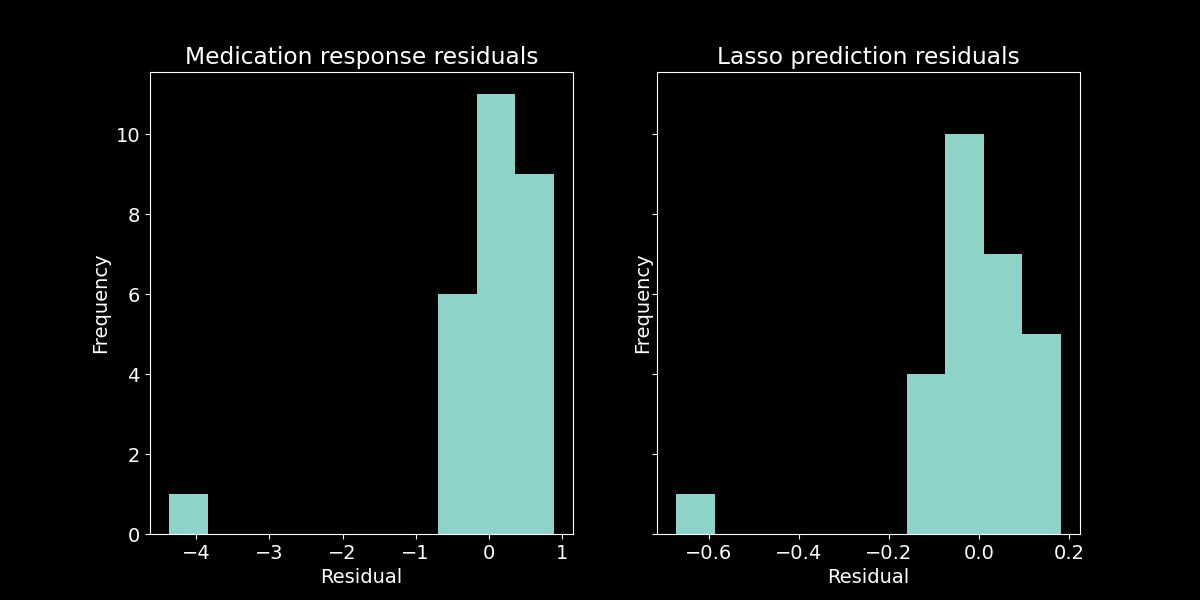

In [53]:
[fig,ax] = plt.subplots(1,2,sharex=False,sharey=True)
ax[0].hist([residual_lct])
ax[0].set_title('Medication response residuals')
ax[0].set_xlabel('Residual')
ax[0].set_ylabel('Frequency')
ax[1].hist([residual_ut])
ax[1].set_title('Lasso prediction residuals')
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Frequency')
fig.set_size_inches(12,6)